# Import Statements and Magic Commands

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_log_error
# WHEN CHECKING THE MODEL: use as np.sqrt(mean_squared_log_error( y_test, predictions ))
from pandas.tseries.holiday import USFederalHolidayCalendar
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import metrics
%matplotlib inline

---
# Load the Data

### Building and Weather Data

In [2]:
# Note: These assume that the data has been saved to a subdirectory named "energy"
bldgData = pd.read_csv("energy/building_metadata.csv")
weatherTrain = pd.read_csv("energy/weather_train.csv")
weatherTest = pd.read_csv("energy/weather_test.csv")
allWeather = weatherTrain.append(weatherTest)

I'm combining the weather data into one dataframe. There's really no need for it to be separate. Plus, I have a hunch that the _current_ meter reading is better modeled as a function of the average of the _current_ weather data and the _last_ weather data. In other words, how much energy a building used in the last hour is based on the weather for the last hour, not necessarily the weather at the current timestamp. If this is the case, then the first prediction in the test data will need the last weather data from the training set.

### Training Data

In [3]:
energyTrain = pd.read_csv("energy/train.csv")

### Test Data
Warning: This will use a lot of memory! My virtual machine is sitting at 5.5 GB of RAM utilization right now.

In [4]:
energyTest = pd.read_csv("energy/test.csv")

### Explore the Data

In [5]:
print(bldgData.head(5))
print(allWeather.head(5))
#print(allWeather.tail(5))
print(energyTrain.head(5))

   site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN
   site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2016-01-01 00:00:00             25.0             6.0   
1        0  2016-01-01 01:00:00             24.4             NaN   
2        0  2016-01-01 02:00:00             22.8             2.0   
3        0  2016-01-01 03:00:00             21.1             2.0   
4        0  2016-01-01 04:00:00             20.0             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0                NaN              1019.7             

---
# 0. No Model

Just submit the "sample_submission.csv" and see what score that yields.

### Kaggle RMSLE score for No Model = 

---
# 1.a. The "Naïve Model" - Version 1

This model computes the average usage for a `(building_id, meter, hourly time)` tuple. This version of the Naïve Model is not aware of "workdays" vs. "non-workdays" (i.e. weekends and holidays).

**Train**

In [6]:
naiveModel = {}

for row in energyTrain.itertuples(index=False):
    building_id = str(row.building_id)
    meter = str(row.meter)
    time = row.timestamp.split(" ")[1]
    meter_reading = row.meter_reading
    
    key = building_id + "-" + meter + "-" + time
    
    if key in naiveModel:
        naiveModel[key][0] += meter_reading
        naiveModel[key][1] += 1.0
    else:
        naiveModel[key] = [meter_reading,1.0]
        
for key in naiveModel.keys():
    totalUsed = naiveModel[key][0]
    readingCount = naiveModel[key][1]
    naiveModel[key] = totalUsed / readingCount

print(naiveModel)

{'0-0-00:00:00': 146.7318142076503, '1-0-00:00:00': 74.31176448087434, '2-0-00:00:00': 7.909866120218582, '3-0-00:00:00': 226.09059754098354, '4-0-00:00:00': 939.8014480874317, '5-0-00:00:00': 14.828896994535565, '6-0-00:00:00': 64.51872540983607, '7-0-00:00:00': 299.99732513661206, '8-0-00:00:00': 229.94260655737693, '9-0-00:00:00': 56.95684808743167, '10-0-00:00:00': 824.1969316939891, '11-0-00:00:00': 292.1693169398905, '12-0-00:00:00': 150.7227442622951, '13-0-00:00:00': 184.7947841530054, '14-0-00:00:00': 178.3496420765027, '15-0-00:00:00': 118.53797267759558, '16-0-00:00:00': 802.9102158469941, '17-0-00:00:00': 59.86387650273227, '18-0-00:00:00': 1223.8417213114758, '19-0-00:00:00': 117.4764262295082, '20-0-00:00:00': 266.0975983606555, '21-0-00:00:00': 44.489502185792375, '22-0-00:00:00': 16.675217213114756, '23-0-00:00:00': 490.98085792349747, '24-0-00:00:00': 411.4271584699452, '25-0-00:00:00': 162.3849890710384, '26-0-00:00:00': 43.1120644808743, '27-0-00:00:00': 177.49827868

**Predict**

In [94]:
# Note: Create a subdirectory named "results" before running
naiveResults = "row_id,meter_reading\n"

for row in energyTest.itertuples(index=False):
    row_id = str(row.row_id)
    building_id = str(row.building_id)
    meter = str(row.meter)
    time = row.timestamp.split(" ")[1]
    
    key = building_id + "-" + meter + "-" + time
    
    pred = naiveModel[key]

    naiveResults += row_id + "," + '{0:.4f}'.format(pred) + "\n"
    
outFile = open("results/naiveResults01.csv","w")
outFile.write(naiveResults)
outFile.close()

NameError: name 'naiveModel' is not defined

In [8]:
resultTest = pd.read_csv("results/naiveResults01.csv")
print(resultTest.head(5))

   row_id  meter_reading
0       0       146.7318
1       1        74.3118
2       2         7.9099
3       3       226.0906
4       4       939.8014


### Kaggle RMSLE score for the Naïve Method, Version 1 = 1.46

---
# 1.b. The "Naïve Model" - Version 2

This model improves on Version 1 by computing two averages for each `(building_id, meter, hourly time)` tuple: one for "workdays" and one for "non-workdays" (i.e. weekends and holidays).

**Train**

In [9]:
cal = USFederalHolidayCalendar() # This assumes all of the buildings are in the US, but they are not.
holidays = cal.holidays(start='2016-01-01', end='2018-12-31').to_pydatetime()

naiveModel = {}

for row in energyTrain.itertuples(index=False):
    building_id = str(row.building_id)
    meter = str(row.meter)
    dateStr, time = row.timestamp.split(" ")
    meter_reading = row.meter_reading
    
    date = datetime.datetime.strptime(dateStr, '%Y-%m-%d')
    
    if (date in holidays) or (date.weekday() > 4):
        workday = '0'
    else:
        workday = '1'
    
    key = workday + "-" + building_id + "-" + meter + "-" + time
    
    if key in naiveModel:
        naiveModel[key][0] += meter_reading
        naiveModel[key][1] += 1.0
    else:
        naiveModel[key] = [meter_reading,1.0] 
        
for key in naiveModel.keys():
    totalUsed = naiveModel[key][0]
    readingCount = naiveModel[key][1]
    naiveModel[key] = totalUsed / readingCount

KeyboardInterrupt: 

**Predict**

In [ ]:
# Note: Create a subdirectory named "results" before running
naiveResults = "row_id,meter_reading\n"

for row in energyTest.itertuples(index=False):
    row_id = str(row.row_id)
    building_id = str(row.building_id)
    meter = str(row.meter)
    dateStr, time = row.timestamp.split(" ")
    
    date = datetime.datetime.strptime(dateStr, '%Y-%m-%d')
    
    if (date in holidays) or (date.weekday() > 4):
        workday = '0'
    else:
        workday = '1'
    
    key = workday + "-" + building_id + "-" + meter + "-" + time
    
    pred = naiveModel[key]

    naiveResults += row_id + "," + '{0:.4f}'.format(pred) + "\n"
    
    print(naiveResults)
    
outFile = open("results/naiveResults02.csv","w")
outFile.write(naiveResults)
outFile.close()

### Kaggle RMSLE score for the Naïve Method, Version 2 = 1.45

---
# Intermission: Merge Training Data prior to Machine Learning

In [5]:
trainJoinBldg = pd.merge(energyTrain, bldgData, on='building_id')
fullTraining = pd.merge(trainJoinBldg, allWeather, how='left', on=['site_id', 'timestamp'])

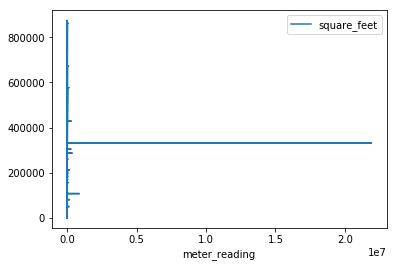

In [7]:
fullTraining.plot(x='meter_reading', y='square_feet')

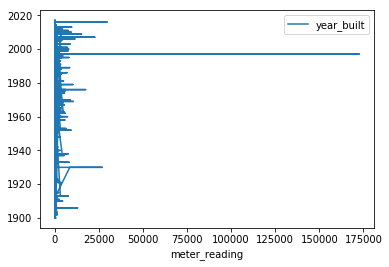

In [8]:
fullTraining.plot(x='year_built', y='meter_reading')

In [89]:
# Explore new dataframes
print(energyTrain.shape)
print(trainJoinBldg.shape)
thrownOut = energyTrain.shape[0] - trainJoinBldg.shape[0]
thrownOutPercent = 100.* thrownOut * 1./ energyTrain.shape[0]
print("% thrown out by merging with building data: " + '{0:.2f}'.format(thrownOutPercent) + "%")
print(fullTraining.shape)
thrownOut = trainJoinBldg.shape[0] - fullTraining.shape[0]
thrownOutPercent = 100.* thrownOut * 1./ trainJoinBldg.shape[0]
print("% thrown out by merging with weather data: " + '{0:.2f}'.format(thrownOutPercent) + "%")
#print(trainJoinBldg.head(5))
#print(fullTraining.head(5))
print(fullTraining.columns)

(20216100, 4)
(20216100, 9)
% thrown out by merging with building data: 0.00%
(20216100, 16)
% thrown out by merging with weather data: 0.00%
Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')


In [75]:
print(fullTraining.head(5000))

      building_id  meter            timestamp  meter_reading  site_id  \
0               0      0  2016-01-01 00:00:00         0.0000        0   
1               1      0  2016-01-01 00:00:00         0.0000        0   
2               2      0  2016-01-01 00:00:00         0.0000        0   
3               3      0  2016-01-01 00:00:00         0.0000        0   
4               4      0  2016-01-01 00:00:00         0.0000        0   
5               5      0  2016-01-01 00:00:00         0.0000        0   
6               6      0  2016-01-01 00:00:00         0.0000        0   
7               7      0  2016-01-01 00:00:00         0.0000        0   
8               8      0  2016-01-01 00:00:00         0.0000        0   
9               9      0  2016-01-01 00:00:00         0.0000        0   
10             10      0  2016-01-01 00:00:00         0.0000        0   
11             11      0  2016-01-01 00:00:00         0.0000        0   
12             12      0  2016-01-01 00:00:00      

`fullTraining` now has all the provided training data merged into one dataframe. i.e. Each row contains the meter reading, building info, and weather for that site+timestamp all in one row.

Only 0.45% of the rows get lost when merging with the weather data. This implies that not every site+timestamp is present in the weather data.

I assume it will also be necessary to repeat these steps for the test data prior to making predictions; however, if weather data is not present for a given site+timestamp, we cannot just drop the row - we must still make a prediction.

---
# 2. Linear Regression

I have a hunch that we'll need separate models for workdays and holidays/weekends.
So, we may end up needing a model for each of the following:

* workday / electricity
* workday / chilledwater
* workday / steam
* workday / hotwater
* non-workday / electricity
* non-workday / chilledwater
* non-workday / steam
* non-workday / hotwater

And we could maybe even add the `primary_use` as yet another variable if we really want/need to.

---
# 2. Sample General Linear Regression Model

In [12]:
fullTraining.describe()

building_id         meter  meter_reading       site_id   square_feet  \
count  2.012560e+07  2.012560e+07   2.012560e+07  2.012560e+07  2.012560e+07   
mean   7.972116e+02  6.617305e-01   2.124813e+03  7.967773e+00  1.077848e+05   
std    4.263729e+02  9.310748e-01   1.535796e+05  5.092223e+00  1.171616e+05   
min    0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00  2.830000e+02   
25%    3.910000e+02  0.000000e+00   1.830000e+01  3.000000e+00  3.252700e+04   
50%    8.940000e+02  0.000000e+00   7.875000e+01  9.000000e+00  7.270900e+04   
75%    1.176000e+03  1.000000e+00   2.678430e+02  1.300000e+01  1.391130e+05   
max    1.448000e+03  3.000000e+00   2.190470e+07  1.500000e+01  8.750000e+05   

         year_built   floor_count  air_temperature  cloud_coverage  \
count  2.012560e+07  2.012560e+07     2.012560e+07    2.012560e+07   
mean   7.836273e+02  7.252062e-01     1.598306e+01    1.075606e+00   
std    9.637120e+02  2.295898e+00     1.094919e+01    2.038417e+00   
min    0.000000e+00  0.000000e+00    -2.890000e+01    0.000000e+00   
25%    0.000000e+00  0.000000e+00     8.500000e+00    0.000000e+00   
50%    0.000000e+00  0.000000e+00     1.670000e+01    0.000000e+00   
75%    1.964000e+03  0.000000e+00     2.400000e+01    2.000000e+00   
max    2.017000e+03  2.600000e+01     4.720000e+01    9.000000e+00   

       dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
count     2.012560e+07       2.012560e+07        2.012560e+07    2.012560e+07   
mean      7.743716e+00       6.516393e-01        9.584708e+02    1.613359e+02   
std       1.017764e+01       6.763078e+00        2.350936e+02    1.183858e+02   
min      -3.500000e+01      -1.000000e+00        0.000000e+00    0.000000e+00   
25%       0.000000e+00       0.000000e+00        1.010600e+03    5.000000e+01   
50%       8.900000e+00       0.000000e+00        1.015600e+03    1.700000e+02   
75%       1.610000e+01       0.000000e+00        1.020200e+03    2.700000e+02   
max       2.610000e+01       3.430000e+02        1.045500e+03    3.600000e+02   

         wind_speed  
count  2.012560e+07  
mean   3.368600e+00  
std    2.269332e+00  
min    0.000000e+00  
25%    2.100000e+00  
50%    3.100000e+00  
75%    4.600000e+00  
max    1.900000e+01

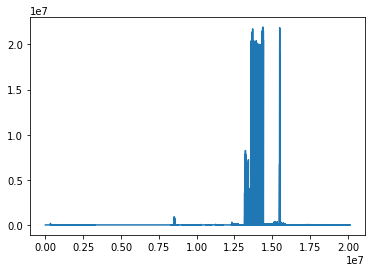

In [128]:
plt.plot(y)
plt.show()

In [8]:
#Splitting into features and labels
X = fullTraining2[['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_direction', 'wind_speed']].values
#X = fullTraining[['air_temperature', 'dew_temperature']].values
y = fullTraining2['meter_reading'].values

#replace null values with column means
indsX = np.where(np.isnan(X))
col_mean = np.nanmean(X, axis=1)
X[indsX] = np.take(col_mean, indsX[1])

In [7]:
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Coefficients

In [8]:
coeff_df = pd.DataFrame(regressor.coef_, [['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']], columns=['Coefficient'])  
#coeff_df = pd.DataFrame(regressor.coef_, [['air_temperature', 'dew_temperature']], columns=['Coefficient'])  
coeff_df

Coefficient
square_feet            0.032131
year_built            -2.459565
floor_count            1.107654
air_temperature        2.129612
cloud_coverage         0.062166
dew_temperature       -7.816598
precip_depth_1_hr     -0.168671
sea_level_pressure     0.126288
wind_direction        -0.347320
wind_speed            -0.078368

---
# Testing General Linear Regression Model

In [9]:
testJoinBldg = pd.merge(energyTest, bldgData, on='building_id')
fullTesting = pd.merge(testJoinBldg, allWeather, how='left', on=['site_id', 'timestamp'])

In [10]:
X_test = fullTesting[['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']].values
#X_test = fullTesting[['air_temperature', 'dew_temperature']].values

In [11]:
inds = np.where(np.isnan(X_test))

In [12]:
col_mean = np.nanmean(X_test, axis=1)
X_test[inds] = np.take(col_mean, inds[1])

In [13]:
y_pred = regressor.predict(X_test)

In [16]:
print(y_pred[:5])

[-3681.90173244 -3823.46345567 -3706.14990701 -3144.92365245
   -92.86407147]


In [15]:
print(X_test[:5])

[[7.4320000e+03 2.0080000e+03 1.0656875e+03 1.7800000e+01 4.0000000e+00
  1.1700000e+01 3.8831875e+03 1.0214000e+03 1.0000000e+02 3.6000000e+00]
 [2.7200000e+03 2.0040000e+03 1.0656875e+03 1.7800000e+01 4.0000000e+00
  1.1700000e+01 3.8831875e+03 1.0214000e+03 1.0000000e+02 3.6000000e+00]
 [5.3760000e+03 1.9910000e+03 1.0656875e+03 1.7800000e+01 4.0000000e+00
  1.1700000e+01 3.8831875e+03 1.0214000e+03 1.0000000e+02 3.6000000e+00]
 [2.3685000e+04 2.0020000e+03 1.0656875e+03 1.7800000e+01 4.0000000e+00
  1.1700000e+01 3.8831875e+03 1.0214000e+03 1.0000000e+02 3.6000000e+00]
 [1.1660700e+05 1.9750000e+03 1.0656875e+03 1.7800000e+01 4.0000000e+00
  1.1700000e+01 3.8831875e+03 1.0214000e+03 1.0000000e+02 3.6000000e+00]]


---
# 2. Sample General Linear Regression Model 2 - feature manipulation

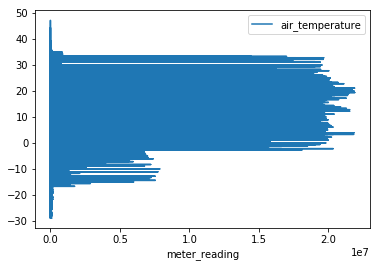

In [6]:
#air_temp = fullTraining['air_temperature'].values
#meter_readings = fullTraining['meter_reading'].values
#print(air_temp.shape)
#print(meter_readings.shape)
#print(air_temp.min())
#print(np.amin(air_temp, out=meter_readings))
#fullTraining.plot(x='meter_reading', y='air_temperature')
#plt.scatter(fullTesting['air_temperature'], fullTesting['air_temperature'])
#plt.show()

In [135]:
fullTraining2 = fullTraining
airTempMean = fullTraining2['air_temperature'].mean()
fullTraining2['air_temperature'] - airTempMean
fullTraining2['air_temperature'] = fullTraining2['air_temperature'].abs()
dewTempMean = fullTraining2['dew_temperature'].mean()
fullTraining2['dew_temperature'] - dewTempMean
fullTraining2['dew_temperature'] = fullTraining2['dew_temperature'].abs()
fullTraining2['year_built'] = 2019 - fullTraining2['year_built']

In [91]:
fullTraining2.describe()

building_id         meter  meter_reading       site_id   square_feet  \
count  2.021610e+07  2.021610e+07   2.021610e+07  2.021610e+07  2.021610e+07   
mean   7.992780e+02  6.624412e-01   2.117121e+03  7.992232e+00  1.077830e+05   
std    4.269133e+02  9.309921e-01   1.532356e+05  5.099060e+00  1.171424e+05   
min    0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00  2.830000e+02   
25%    3.930000e+02  0.000000e+00   1.830000e+01  3.000000e+00  3.252700e+04   
50%    8.950000e+02  0.000000e+00   7.877500e+01  9.000000e+00  7.270900e+04   
75%    1.179000e+03  1.000000e+00   2.679840e+02  1.300000e+01  1.391130e+05   
max    1.448000e+03  3.000000e+00   2.190470e+07  1.500000e+01  8.750000e+05   

         year_built   floor_count  air_temperature  cloud_coverage  \
count  8.088455e+06  3.506933e+06     2.011944e+07    1.139074e+07   
mean   5.072326e+01  4.184848e+00     1.689227e+01    1.900423e+00   
std    3.020815e+01  4.008277e+00     9.492578e+00    2.402909e+00   
min    2.000000e+00  1.000000e+00     0.000000e+00    0.000000e+00   
25%    2.600000e+01  1.000000e+00     9.300000e+00    0.000000e+00   
50%    5.000000e+01  3.000000e+00     1.700000e+01    0.000000e+00   
75%    6.800000e+01  6.000000e+00     2.440000e+01    4.000000e+00   
max    1.190000e+02  2.600000e+01     4.720000e+01    9.000000e+00   

       dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
count     2.011596e+07       1.646708e+07        1.898443e+07    1.876705e+07   
mean      1.068902e+01       7.964155e-01        1.016085e+03    1.730151e+02   
std       7.026581e+00       7.468997e+00        7.060539e+00    1.140574e+02   
min       0.000000e+00      -1.000000e+00        9.682000e+02    0.000000e+00   
25%       4.400000e+00       0.000000e+00        1.011600e+03    7.000000e+01   
50%       1.000000e+01       0.000000e+00        1.016000e+03    1.800000e+02   
75%       1.610000e+01       0.000000e+00        1.020500e+03    2.800000e+02   
max       3.500000e+01       3.430000e+02        1.045500e+03    3.600000e+02   

         wind_speed  
count  2.007242e+07  
mean   3.377525e+00  
std    2.265694e+00  
min    0.000000e+00  
25%    2.100000e+00  
50%    3.100000e+00  
75%    4.600000e+00  
max    1.900000e+01

In [136]:
#Splitting into features and labels
X = fullTraining2[['year_built', 'air_temperature', 'dew_temperature']].values
y = fullTraining2['meter_reading'].values

#replace null values with column means
indsX = np.where(np.isnan(X))
col_mean = np.nanmean(X, axis=1)
X[indsX] = np.take(col_mean, indsX[1])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [137]:
print(X.shape)
print(y.shape)

(20216100, 3)
(20216100,)


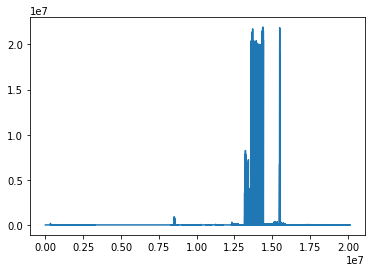

In [128]:
plt.plot(y)
plt.show()

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [139]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Coefficients

In [140]:
coeff_df = pd.DataFrame(regressor.coef_, [['year_built', 'air_temperature', 'dew_temperature']], columns=['Coefficient'])  
#coeff_df = pd.DataFrame(regressor.coef_, [['air_temperature', 'dew_temperature']], columns=['Coefficient'])  
coeff_df

Coefficient
year_built         -2.335449
air_temperature    -1.368348
dew_temperature    -2.063452

In [141]:
y_pred = regressor.predict(X_test)

In [142]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)
df1

Actual    Predicted
0    109.0000  3348.859663
1     17.4250  3346.646260
2      4.1231   417.346824
3   1089.8000  3342.871281
4     82.9440   316.509866
5     65.4333  3337.567073
6      6.0000  3288.800991
7      8.7921   315.398601
8    185.0000  3334.467967
9      0.3332  3351.902375
10   156.0000  3329.810769
11  1099.9400  3349.980130
12   800.2930  3308.253831
13    35.6946  3338.574752
14    20.3000  3310.742645
15   202.9180  3282.966932
16   520.6700  3291.779008
17   639.6950   203.034417
18    12.0000  3281.728861
19    54.2294  3315.718532
20    14.3430   349.334449
21    10.2000   398.404862
22   899.6400  3336.272608
23    76.2805  3286.033691
24    93.4900  3280.280073

In [143]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3783.9188629980654
Mean Squared Error: 23906148884.744812
Root Mean Squared Error: 154616.1339729616


---
# Testing Linear Regression Model 2

In [118]:
testJoinBldg = pd.merge(energyTest, bldgData, sort=True, on='building_id')
fullTesting2 = pd.merge(testJoinBldg, allWeather, sort=True, how='left', on=['site_id', 'timestamp'])

In [119]:
# Explore new dataframes
print(energyTest.shape)
print(testJoinBldg.shape)
thrownOut = energyTest.shape[0] - testJoinBldg.shape[0]
thrownOutPercent = 100.* thrownOut * 1./ energyTest.shape[0]
print("% thrown out by merging with building data: " + '{0:.2f}'.format(thrownOutPercent) + "%")
print(fullTesting2.shape)
thrownOut = testJoinBldg.shape[0] - fullTesting2.shape[0]
thrownOutPercent = 100.* thrownOut * 1./ trainJoinBldg.shape[0]
print("% thrown out by merging with weather data: " + '{0:.2f}'.format(thrownOutPercent) + "%")
#print(trainJoinBldg.head(5))
#print(fullTraining.head(5))
print(fullTesting2.columns)

(41697600, 4)
(41697600, 9)
% thrown out by merging with building data: 0.00%
(41697600, 16)
% thrown out by merging with weather data: 0.00%
Index(['row_id', 'building_id', 'meter', 'timestamp', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed'],
      dtype='object')


In [120]:
tempMean = fullTesting2['air_temperature'].mean()
fullTesting2['air_temperature'] - tempMean
fullTesting2['air_temperature'] = fullTesting2['air_temperature'].abs()
dewtempMean = fullTesting2['dew_temperature'].mean()
fullTesting2['dew_temperature'] - dewtempMean
fullTesting2['dew_temperature'] = fullTesting2['dew_temperature'].abs()
fullTesting2['year_built'] = 2019 - fullTesting2['year_built']

In [121]:
X_test = fullTesting2[['year_built', 'air_temperature', 'dew_temperature']].values
#X_test = fullTesting[['air_temperature', 'dew_temperature']].values

In [124]:
print(fullTesting2.shape)
print(X_test.shape)

(41697600, 16)
(41697600, 3)


In [125]:
inds = np.where(np.isnan(X_test))

In [126]:
col_mean = np.nanmean(X_test, axis=1)
X_test[inds] = np.take(col_mean, inds[1])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [127]:
y_test_pred = regressor.predict(X_test)

In [128]:
print(y_test_pred[:5])

[2870.51834273 2697.68288332 2135.96764022 2611.26515361 1444.62580256]


In [129]:
print(X_test[:5])

[[11.  17.8 11.7]
 [15.  17.8 11.7]
 [28.  17.8 11.7]
 [17.  17.8 11.7]
 [44.  17.8 11.7]]


In [130]:
row_ids = fullTesting2['row_id']
pred = pd.DataFrame(y_test_pred)
linear01 = pd.concat([row_ids, pred], axis=1)
linear01.columns = ['row_id', 'meter_reading']

In [131]:
print(linear01.head(5))
print(linear01.columns)
print(linear01.shape)
print(row_ids.head(5))

   row_id  meter_reading
0       0    2870.518343
1       1    2697.682883
2       2    2135.967640
3       3    2611.265154
4       4    1444.625803
Index(['row_id', 'meter_reading'], dtype='object')
(41697600, 2)
0    0
1    1
2    2
3    3
4    4
Name: row_id, dtype: int64


In [132]:
linear01.to_csv('linearRegression01.csv', index=False)

In [133]:
resultTest = pd.read_csv("linearRegression01.csv")
print(resultTest.head(5))

   row_id  meter_reading
0       0    2870.518343
1       1    2697.682883
2       2    2135.967640
3       3    2611.265154
4       4    1444.625803


In [134]:
print(resultTest.shape)

(41697600, 2)


# Feature Selection

In [62]:
fullTraining2 = fullTraining
airTempMean = fullTraining2['air_temperature'].mean()
fullTraining2['air_temperature'] - airTempMean
fullTraining2['air_temperature'] = fullTraining2['air_temperature'].abs()
dewTempMean = fullTraining2['dew_temperature'].mean()
fullTraining2['dew_temperature'] - dewTempMean
fullTraining2['dew_temperature'] = fullTraining2['dew_temperature'].abs()

In [63]:
#Splitting into features and labels
X = fullTraining2[['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_direction', 'wind_speed']].values
#X = fullTraining[['air_temperature', 'dew_temperature']].values
y = fullTraining2['meter_reading'].values

#replace null values with column means
indsX = np.where(np.isnan(X))
col_mean = np.nanmean(X, axis=1)
X[indsX] = np.take(col_mean, indsX[1])

In [64]:
X_feat = pd.DataFrame(X)
y_feat = pd.DataFrame(y)

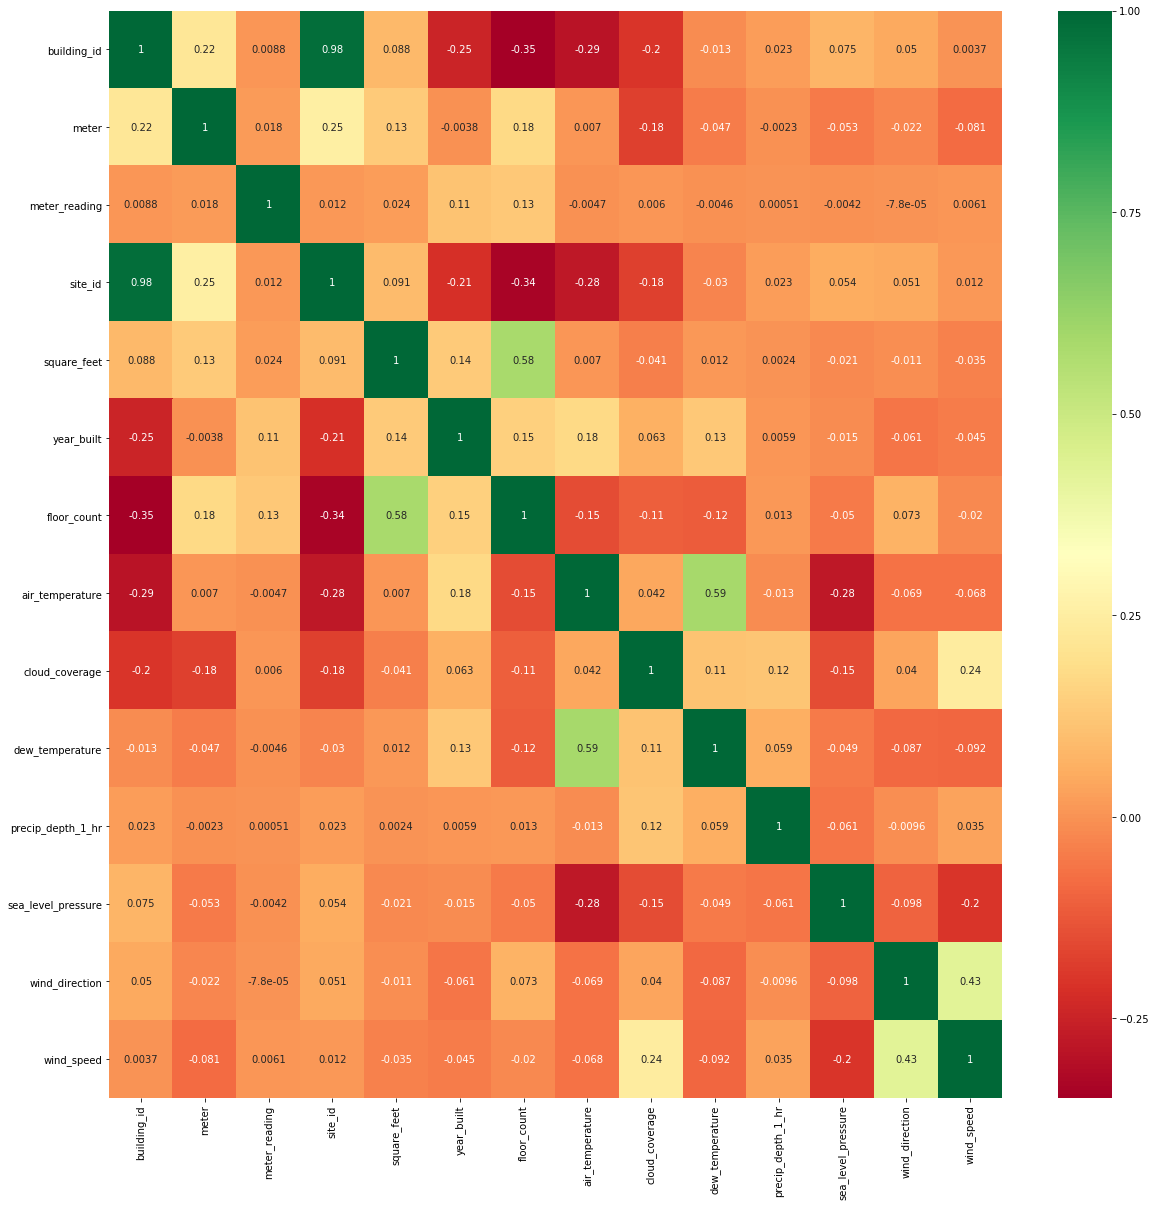

In [65]:
corrmat = fullTraining2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=seabornInstance.heatmap(fullTraining2[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Linear Regression Model 3

In [69]:
fullTraining3 = fullTraining
fullTraining3['year_built'] = -fullTraining3['year_built'] + 2019
q = fullTraining3["meter_reading"].quantile(0.99)
fullTraining3 = fullTraining3[fullTraining3["meter_reading"] < q]
fullTraining3 = fullTraining3[fullTraining3["meter_reading"] > -q]
#fullTraining3['year_built'] = -fullTraining3['year_built'] + 2019

In [71]:
# Explore new dataframes
print(fullTraining.shape)
print(fullTraining3.shape)
thrownOut = fullTraining.shape[0] - fullTraining3.shape[0]
thrownOutPercent = 100.* thrownOut * 1./ fullTraining.shape[0]
print("% thrown out by merging with building data: " + '{0:.2f}'.format(thrownOutPercent) + "%")

(20216100, 16)
(20013897, 16)
% thrown out by merging with building data: 1.00%


In [72]:
#Splitting into features and labels
X = fullTraining3[['year_built', 'floor_count']].values
y = fullTraining3['meter_reading'].values

#replace null values with column means
indsX = np.where(np.isnan(X))
col_mean = np.nanmean(X, axis=1)
X[indsX] = np.take(col_mean, indsX[1])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [74]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Coefficients

In [75]:
coeff_df = pd.DataFrame(regressor.coef_, [['year_built', 'floor_count']], columns=['Coefficient'])  
coeff_df

Coefficient
year_built     -1.224691
floor_count    22.451837

In [76]:
y_pred = regressor.predict(X_test)

In [77]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)
df1

Actual   Predicted
0     23.9550  335.612958
1     46.2200  335.612958
2     57.4375  335.612958
3    176.6860  335.612958
4     28.7000  335.612958
5      0.0000  301.321623
6     29.3071  285.400646
7      0.0000  335.612958
8   1337.2200  296.422861
9    102.3760  327.040124
10   156.7800  335.612958
11    18.7500  121.706931
12   375.0700  333.163577
13   549.2400  253.558693
14    26.0000  335.612958
15     0.0000  335.612958
16   214.2500  173.548871
17    86.8200  240.087097
18    46.1333  335.612958
19    73.3263  246.210549
20   488.0000  335.612958
21    16.0000  335.612958
22    22.0000  219.267358
23    70.0000  335.612958
24     0.0000  308.669766

In [78]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 329.17664908105417
Mean Squared Error: 371609.6597010172
Root Mean Squared Error: 609.5979492263874


---
# Testing Linear Regression Model 2

In [79]:
testJoinBldg = pd.merge(energyTest, bldgData, sort=True, on='building_id')
fullTesting3 = pd.merge(testJoinBldg, allWeather, sort=True, how='left', on=['site_id', 'timestamp'])

In [80]:
fullTesting3['year_built'] = -fullTesting3['year_built'] + 2019

In [81]:
X_test = fullTesting3[['year_built', 'floor_count']].values

In [82]:
inds = np.where(np.isnan(X_test))
col_mean = np.nanmean(X_test, axis=1)
X_test[inds] = np.take(col_mean, inds[1])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [83]:
y_test_pred = regressor.predict(X_test)

In [84]:
print(y_test_pred[:5])

[425.42030405 420.52154194 404.60056506 418.07216088 385.0055166 ]


In [85]:
print(X_test[:5])

[[11. 15.]
 [15. 15.]
 [28. 15.]
 [17. 15.]
 [44. 15.]]


In [86]:
row_ids = fullTesting3['row_id']
pred = pd.DataFrame(y_test_pred)
linear01 = pd.concat([row_ids, pred], axis=1)
linear01.columns = ['row_id', 'meter_reading']

In [87]:
print(linear01.head(5))
print(linear01.columns)
print(linear01.shape)
print(row_ids.head(5))

   row_id  meter_reading
0       0     425.420304
1       1     420.521542
2       2     404.600565
3       3     418.072161
4       4     385.005517
Index(['row_id', 'meter_reading'], dtype='object')
(41697600, 2)
0    0
1    1
2    2
3    3
4    4
Name: row_id, dtype: int64


In [91]:
linear01.to_csv('linearRegression03.csv', index=False)

In [92]:
resultTest = pd.read_csv("linearRegression03.csv")
print(resultTest.head(5))

   row_id  meter_reading
0       0     425.420304
1       1     420.521542
2       2     404.600565
3       3     418.072161
4       4     385.005517


In [93]:
print(resultTest.shape)

(41697600, 2)


# Linear Regression Separate Models

In [31]:
trainJoinBldg = pd.merge(energyTrain, bldgData, on='building_id')
fullTraining = pd.merge(trainJoinBldg, allWeather, how='left', on=['site_id', 'timestamp'])

In [32]:
fullTraining4 = fullTraining
fullTraining4["timestamp"] = pd.to_datetime(fullTraining4["timestamp"])

In [33]:
fullTraining4['workday'] = [1 if x.weekday() > 4 else 0 for x in fullTraining4['timestamp']]

In [34]:
uses = fullTraining4['primary_use'].unique().tolist()
usage_models = {}

for use in uses:
    usage_models[use + "_model"] = fullTraining4.loc[fullTraining4.primary_use == use]

In [35]:
m = usage_models['Education_model']
m[m['meter_reading'] == 0]['meter'].unique().tolist()

[0, 1, 3, 2]

In [37]:
meters = fullTraining4['meter'].unique().tolist()
usage_meters_models = {}
for use in uses:
    currModel = usage_models[use + "_model"]
    for meter in meters:
        usage_meters_models[use + "_" + str(meter) + "_model"] = currModel.loc[currModel.meter == meter]

In [41]:
usage_meters_workday_models = {}
for model in usage_meters_models:
    usage_meters_workday_models["workday_" + model] = usage_meters_models[model].loc[usage_meters_models[model].workday == 0]
    usage_meters_workday_models["nonworkday_" + model] = usage_meters_models[model].loc[usage_meters_models[model].workday == 1]

In [42]:
print(usage_meters_workday_models)

{'workday_Education_0_model':           building_id  meter           timestamp  meter_reading  site_id  \
0                   0      0 2016-01-01 00:00:00           0.00        0   
1                   0      0 2016-01-01 01:00:00           0.00        0   
2                   0      0 2016-01-01 02:00:00           0.00        0   
3                   0      0 2016-01-01 03:00:00           0.00        0   
4                   0      0 2016-01-01 04:00:00           0.00        0   
5                   0      0 2016-01-01 05:00:00           0.00        0   
6                   0      0 2016-01-01 06:00:00           0.00        0   
7                   0      0 2016-01-01 07:00:00           0.00        0   
8                   0      0 2016-01-01 08:00:00           0.00        0   
9                   0      0 2016-01-01 09:00:00           0.00        0   
10                  0      0 2016-01-01 10:00:00           0.00        0   
11                  0      0 2016-01-01 11:00:00          

In [45]:
means = {}
for model in usage_meters_workday_models:
    means[model + "_mean"] = usage_meters_workday_models[model]['meter_reading'].mean()

In [46]:
print(means)

{'workday_Education_0_model_mean': 256.2888294550256, 'nonworkday_Education_0_model_mean': 218.44459423181456, 'workday_Education_1_model_mean': 760.7213778527018, 'nonworkday_Education_1_model_mean': 676.4661182015586, 'workday_Education_3_model_mean': 303.44429312390514, 'nonworkday_Education_3_model_mean': 292.04138466842807, 'workday_Education_2_model_mean': 32373.93437770175, 'nonworkday_Education_2_model_mean': 26203.45586946242, 'workday_Lodging/residential_0_model_mean': 109.40492711936814, 'nonworkday_Lodging/residential_0_model_mean': 106.58367922008107, 'workday_Lodging/residential_1_model_mean': 424.18177965353453, 'nonworkday_Lodging/residential_1_model_mean': 401.8076737462363, 'workday_Lodging/residential_3_model_mean': 57.32124591515013, 'nonworkday_Lodging/residential_3_model_mean': 57.80562819636315, 'workday_Lodging/residential_2_model_mean': 764.4054470857253, 'nonworkday_Lodging/residential_2_model_mean': 689.0229581367369, 'workday_Office_0_model_mean': 165.884235